In [ ]:
# [TODO]: Add 10000 scaling properly

In [43]:
import math
import fiona
# import pygeos
import networkx as nx
import osmnx as ox
import geopandas as gp
import pandas as pd

import numpy as np
from random import random

%matplotlib inline
ox.config(log_console=True)
ox.__version__

from skgeom import Point2,Segment2,arrangement,intersection,RotationalSweepVisibility, draw
from shapely.geometry import Polygon,Point, MultiPoint, box
from shapely.ops import nearest_points

from queue import PriorityQueue

np.random.seed(2021)


## skgeom functions

In [3]:
def asPoint(point2):
    return Point(point2.bbox().xmax(),point2.bbox().ymax())

In [4]:
def asPoint2(point):
    return Point2(point.x,point.y)

In [5]:
def intersectHelper(segment, node:list):
    '''
        Intersection helper to find the same between a halfedge and a node (list of segments).
        @returns-> List of segments
    '''
    ret = []
    part1 = Segment2(segment.source().point(), segment.target().point())

    for segs in node:
        isx = intersection(part1, segs)
        if type(isx) == Segment2:
            ret.append(isx)

    return ret

In [6]:
def updateVisibility(queryPoint:Point2, node:list, arrangement:arrangement, visReg:list = None):
    '''
        Plain visible region calculation
        @args:
            query point:Point2  --> query point
            node:[segments] --> Target node
            arrangement:Arrangement --> The arrangement (see docs)
            visReg:[segments] --> list of visible segments (after first pass) 
        @returns:
            visible region:[segments]
    '''
    vs = RotationalSweepVisibility(arrangement)
    face = arrangement.find(queryPoint)
    vx = vs.compute_visibility(queryPoint, face)
    vis = []

    # Draw visibility --optional, should be removed in prod
    # for he in arr.halfedges:
    #     draw.draw(he.curve(), visible_point=False)
    # draw.draw(queryPoint, color='magenta')

    if(visReg == None):
        for v in vx.halfedges:
            vis+=intersectHelper(v,node)
    else:
        for v in vx.halfedges:
            vis+=intersectHelper(v,visReg)

    ret = []
    [ret.append(x) for x in vis if x not in ret]
    # for v in ret:
    #     draw.draw(v, color='red', visible_point=False)
    return ret

In [7]:
gdf = gp.read_file("obstacles400.gpkg")
qpGdf = gp.read_file("querypoints.gpkg")


In [8]:
'''
    Preprocessing our obstacle GeoDataFrame

        1. Simplifying building geometries
        2. Adding centroids
        x. Removing some obstacles randomly (not for prod?)
'''

# envelope : convert to rectangles, simplify: reduce edges (also see shapely/geopandas docs)
simple = gdf['geometry'].convex_hull # REMOVING HOLES
simple = simple.simplify(0.5) # EDGE REDUCTION

# simple = gdf['geometry'].simplify(0.5) 
# simple = gdf['geometry'].envelope # RECTANGLE APPROXIMATION ORIENTED WITH THE AXES
gdf['geometry'] = simple

# gdf = gdf.set_crs("EPSG:3035", allow_override=True)
gdf['centroid'] = gdf.centroid

gdf = gdf.sample(frac=0.4)
print(gdf.shape)

(42, 60)


In [9]:
'''
    Building TARGET.
'''
# Random Target
# Target = gdf.sample(n=1)

# Specific Target
Target = gdf.loc[gdf['name'] == 'Museum of Contemporary Art'] # comment frac.

print(Target)

# index_n = gdf[gdf['osmid'] == Target.osmid].index
gdf.drop(Target.index, inplace=True)

  element_type      osmid access         source                        name  \
8          way  206463626   None  USGS Geonames  Museum of Contemporary Art   

  amenity parking tourism    addr:city addr:housenumber  ... contact:phone  \
8    None    None  museum  Los Angeles              250  ...          None   

  contact:website proposed:building  ways  type capacity theatre:genre layer  \
8            None              None  None  None     None          None  None   

                                            geometry  \
8  POLYGON ((-118.25071 34.05282, -118.25102 34.0...   

                      centroid  
8  POINT (-118.25053 34.05329)  

[1 rows x 60 columns]


<AxesSubplot:>

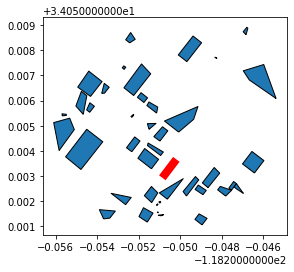

In [10]:
base = gdf.plot(edgecolor='black')
Target.plot(ax=base, color='red')

<AxesSubplot:>

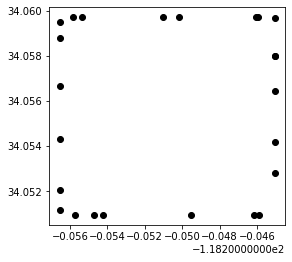

In [11]:
qpGdf.plot(color="black")

In [12]:
'''
    Visibility skgeom construction
'''
minx, miny, maxx, maxy = gdf.total_bounds*10000
minx-=10
miny-=10
maxx+=10
maxx+=10
outer = [
    Segment2(Point2(minx,miny), Point2(minx,maxy)), Segment2(Point2(minx,maxy), Point2(maxx,maxy)),
    Segment2(Point2(maxx,maxy), Point2(maxx,miny)), Segment2(Point2(maxx,miny), Point2(minx,miny))
]
arr = arrangement.Arrangement()

for bounds in outer:
    arr.insert(bounds)

Boundary = Polygon([(minx,miny),(minx,maxy),(maxx,maxy),(maxx,miny)])

In [13]:
list(Boundary.exterior.coords)

[(-1182570.915, 340500.45),
 (-1182570.915, 340589.228),
 (-1182433.945, 340589.228),
 (-1182433.945, 340500.45),
 (-1182570.915, 340500.45)]

In [14]:
list(Target.geometry.exterior.iloc[0].coords)

[(-118.25071, 34.052825),
 (-118.2510219, 34.0530208),
 (-118.2503479, 34.0537551),
 (-118.2500371, 34.0535601),
 (-118.25071, 34.052825)]

In [15]:
'''
    Inserting Target in our arrangement
'''
targetVx = Target.geometry.exterior.iloc[0].coords
targetBuilder = []

# [TODO] Build a duplicate checker since skgeom throws an error
for i in range(len(targetVx)-1):
    targetBuilder.append(Segment2(Point2(targetVx[i][0]*10000,targetVx[i][1]*10000), Point2(targetVx[i+1][0]*10000,targetVx[i+1][1]*10000)))

for bounds in targetBuilder:
    arr.insert(bounds)


In [16]:
targetBuilder

[Segment_2(PointC2(-1.18251e+06, 340528), PointC2(-1.18251e+06, 340530)),
 Segment_2(PointC2(-1.18251e+06, 340530), PointC2(-1.1825e+06, 340538)),
 Segment_2(PointC2(-1.1825e+06, 340538), PointC2(-1.1825e+06, 340536)),
 Segment_2(PointC2(-1.1825e+06, 340536), PointC2(-1.18251e+06, 340528))]

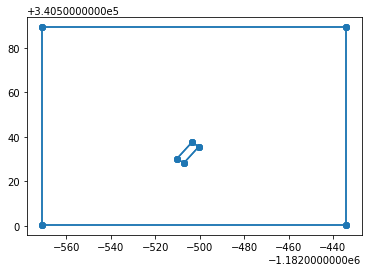

In [17]:
for he in arr.halfedges:
    draw.draw(he.curve())

In [18]:
rtree1 = gdf.sindex

In [19]:
rtree1.query(box(1, 1, 3, 3), predicate="contains")

array([], dtype=int64)

In [20]:
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]
def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = math.acos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360

    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else: 
        return ang_deg

In [21]:
def getLength(vrset:list, queryPoint:Point):
    '''
        Plain visible region calculation
        @args:
            visible region:[segments]
            query point:Point
        @returns:
            length:int
    '''
    lineA = [[queryPoint.x,queryPoint.y],[]]
    lineB = [[],[]]
    dist=0
    for vr in vrset:
        if(vr):
            # print(vr)
            src = asPoint(vr.source())
            tgt = asPoint(vr.target())
            start = [src.x,src.y]
            end = [tgt.x,tgt.y]
            lineA[1] = [(start[0]+end[0])/2,(start[1]+end[1])/2]
            lineB[0] = start
            lineB[1] = end
            angle = ang(lineA,lineB)
            dist+=(angle/90)*src.distance(tgt)
    
    # print(dist)
    return dist


In [22]:
def buildVRPolygons(vis:list, queryPoint:Point):
    '''
        Return set of VR Polygons
        @args:
            visible region:[segments]
            query point:Point
        @returns:
            vrSet:int
    '''
    vrSet = []
    for seg in vis:
        VRvertices = [queryPoint]
        if(seg.source() not in VRvertices):
            VRvertices.append((seg.source().x(),seg.source().y()))
        if(seg.target() not in VRvertices):
            VRvertices.append((seg.target().x(),seg.target().y()))
        vrSet.append(Polygon(VRvertices))
    
    return vrSet

In [49]:
def insideVisibleRegion(visibleRegionSet:list, node:Polygon):
    '''
        Test if VR and (skgeom)polygon intersect
            @args:
                visibilityRegionSet:[Polygons] --> VR from query point
                node:[segments] --> obstacle
            @returns:
                bool --> True when polygon and VR intersect, False o.w.
    '''
    for vrPolygon in visibleRegionSet:
        intersection = node.boundary.intersection(vrPolygon.boundary)
        # print(intersection)
        if isinstance(intersection,MultiPoint):
            return True
    
    return False

In [50]:
def minDist(queryPoint:Point,node:Polygon):
    nPoints = nearest_points(queryPoint,node)
    return nPoints[0].distance(nPoints[1])

In [51]:
def kMaximumVisibility(T,Q,k, gdf):
    '''
        Main algorithm from MV paper
    '''
    L = np.empty(len(Q.index))
    VQ = PriorityQueue()
    LO = np.full(len(Q.index),PriorityQueue())
    CO = set()
    vrset = np.empty(len(Q.index),dtype=object)
    vrPoly = np.empty(len(Q.index),dtype=object)
    end = False
    cont = True
    node = 0 # ?
    trav = rtree1.leaves()
    for ix in Q.index:
        # if(ix==4):
        queryPoint = Point(Q['geometry'][ix].x*10000,Q['geometry'][ix].y*10000)
        if(Boundary.contains(queryPoint)== True):
            vrset[ix] = updateVisibility(asPoint2(queryPoint),T,arr)
            vrPoly[ix] = buildVRPolygons(vrset[ix],queryPoint)
            val = getLength(vrset[ix], queryPoint)
            VQ.put((val, Q['id'][ix]))
    print("Phase 1 OK!")
    # 1.11
    for nodeList in rtree1.leaves():
        for nodeId in nodeList[1]:
            if(end == True):
                break
            # 1.12
            # print(nodeId)
            if(nodeId not in CO):
                node = gdf.iloc[nodeId].geometry
                # node scaling
                vertices = node.exterior.coords
                scaledVx = []
                for vertex in vertices:
                    scaledVx.append((vertex[0]*10000,vertex[1]*10000))
                scaledNode = Polygon(scaledVx)
                for ix in Q.index:
                    if(ix==4):
                        queryPoint = Point(Q['geometry'][ix].x*10000,Q['geometry'][ix].y*10000)
                        if(Boundary.contains(queryPoint)== True):
                            if(insideVisibleRegion(vrPoly[ix],scaledNode)):
                                LO[ix].put(nodeId,minDist(queryPoint,scaledNode))
                CO.add(nodeId)
            # -------------------------------------------------------
            cont = True



ans = kMaximumVisibility(targetBuilder, qpGdf, 2, gdf)

Phase 1 OK!


In [25]:
Boundary.contains(qpGdf['geometry'][0])

False

In [26]:
for ix in qpGdf.index:
        print(ix)
        print(qpGdf['geometry'][ix])

0
POINT (-118.2565573 34.056662)
1
POINT (-118.2565573 34.059508)
2
POINT (-118.2565573 34.058799)
3
POINT (-118.2565573 34.054306)
4
POINT (-118.2565573 34.052081)
5
POINT (-118.2565573 34.051163)
6
POINT (-118.2450453 34.058022)
7
POINT (-118.2450453 34.058006)
8
POINT (-118.2450453 34.054213)
9
POINT (-118.2450453 34.059684)
10
POINT (-118.2450453 34.0528)
11
POINT (-118.2450453 34.056476)
12
POINT (-118.254238 34.050959)
13
POINT (-118.249505 34.050959)
14
POINT (-118.24589 34.050959)
15
POINT (-118.255733 34.050959)
16
POINT (-118.246164 34.050959)
17
POINT (-118.254705 34.050959)
18
POINT (-118.255871 34.0597281)
19
POINT (-118.246021 34.0597281)
20
POINT (-118.250193 34.0597281)
21
POINT (-118.245939 34.0597281)
22
POINT (-118.255369 34.0597281)
23
POINT (-118.251049 34.0597281)
